# Mesh Refinement Tutorial - Cantilevered Hyperelastic Beam

This tutorial is a slight modification of the one found at https://jsdokken.com/dolfinx-tutorial/chapter2/hyperelasticity.html, covering the effects of mesh refinement on the simulation of a cantilevered hyperelastic beam's deflection.

First, we import code dependencies.

In [11]:
import os
import pyvista
import numpy as np

from dolfinx import log, default_scalar_type
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
import ufl
import matplotlib.pyplot as plt

from mpi4py import MPI
from dolfinx import fem, mesh, plot

We define a function to set up, mesh, and solve for the hyperelastic beam's deflection given a specified beam length and mesh sizes in the x, y, and z directions.

In [12]:

def solve_hyperelastic_beam(L: float, mesh_sizes: list, cell_type) -> list:
    # Create the mesh and define a function space over the domain
    domain = mesh.create_box(MPI.COMM_WORLD, [[0.0, 0.0, 0.0], [L, 1, 1]], mesh_sizes, cell_type)
    V = fem.functionspace(domain, ("Lagrange", 2, (domain.geometry.dim, )))

    # Define functions to select the left and right-most facets, for easy boundary condition application
    def left(x):
        return np.isclose(x[0], 0)


    def right(x):
        return np.isclose(x[0], L)

    fdim = domain.topology.dim - 1
    left_facets = mesh.locate_entities_boundary(domain, fdim, left)
    right_facets = mesh.locate_entities_boundary(domain, fdim, right)

    # Concatenate and sort the arrays based on facet indices. Left facets marked with 1, right facets with two
    marked_facets = np.hstack([left_facets, right_facets])
    marked_values = np.hstack([np.full_like(left_facets, 1), np.full_like(right_facets, 2)])
    sorted_facets = np.argsort(marked_facets)
    facet_tag = mesh.meshtags(domain, fdim, marked_facets[sorted_facets], marked_values[sorted_facets])

    # Apply the boundary condition to the left side (fixed)
    u_bc = np.array((0,) * domain.geometry.dim, dtype=default_scalar_type)

    left_dofs = fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(1))
    bcs = [fem.dirichletbc(u_bc, left_dofs, V)]

    # Define the body force and traction
    B = fem.Constant(domain, default_scalar_type((0, 0, 0)))
    T = fem.Constant(domain, default_scalar_type((0, 0, 0)))

    # Create test and solution functions
    v = ufl.TestFunction(V)
    u = fem.Function(V)

    # Specify the kinematic properties
    # Spatial dimension
    d = len(u)

    # Identity tensor
    I = ufl.variable(ufl.Identity(d))

    # Deformation gradient
    F = ufl.variable(I + ufl.grad(u))

    # Right Cauchy-Green tensor
    C = ufl.variable(F.T * F)

    # Invariants of deformation tensors
    Ic = ufl.variable(ufl.tr(C))
    J = ufl.variable(ufl.det(F))

    # Define the hyperelasticity model parameters
    E = default_scalar_type(1.0e4)
    nu = default_scalar_type(0.3)
    mu = fem.Constant(domain, E / (2 * (1 + nu)))
    lmbda = fem.Constant(domain, E * nu / ((1 + nu) * (1 - 2 * nu)))
    # Stored strain energy density (compressible neo-Hookean model)
    psi = (mu / 2) * (Ic - 3) - mu * ufl.ln(J) + (lmbda / 2) * (ufl.ln(J))**2
    # Stress
    # Hyper-elasticity
    P = ufl.diff(psi, F)

    # Define the weak form with traction integral over all facets with value 2. Use a quadtrature degree of 4
    metadata = {"quadrature_degree": 4}
    ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tag, metadata=metadata)
    dx = ufl.Measure("dx", domain=domain, metadata=metadata)
    # Define form F (we want to find u such that F(u) = 0)
    F = ufl.inner(ufl.grad(v), P) * dx - ufl.inner(v, B) * dx - ufl.inner(v, T) * ds(2)

    # Use dolfinx's nonlinear solver
    problem = NonlinearProblem(F, u, bcs)

    # Customize a newton solver method
    solver = NewtonSolver(domain.comm, problem)

    # Set Newton solver options
    solver.atol = 1e-8
    solver.rtol = 1e-8
    solver.convergence_criterion = "incremental"

    # Create a function to plot the deformation results at each time step
    pyvista.start_xvfb()
    plotter = pyvista.Plotter()
    plotter.open_gif(f"b-deformation_{cell_type.name}_{mesh_sizes[0]}_{mesh_sizes[1]}_{mesh_sizes[2]}.gif", fps=3)

    topology, cells, geometry = plot.vtk_mesh(u.function_space)
    function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)

    values = np.zeros((geometry.shape[0], 3))
    values[:, :len(u)] = u.x.array.reshape(geometry.shape[0], len(u))
    function_grid["u"] = values
    function_grid.set_active_vectors("u")

    # Warp mesh by deformation
    warped = function_grid.warp_by_vector("u", factor=1)
    warped.set_active_vectors("u")

    # Add mesh to plotter and visualize
    actor = plotter.add_mesh(warped, show_edges=True, lighting=False, clim=[0, 10])

    # Compute magnitude of displacement to visualize in GIF
    Vs = fem.functionspace(domain, ("Lagrange", 2))
    magnitude = fem.Function(Vs)
    us = fem.Expression(ufl.sqrt(sum([u[i]**2 for i in range(len(u))])), Vs.element.interpolation_points())
    magnitude.interpolate(us)
    warped["mag"] = magnitude.x.array

    # Solve the problem over multiple time steps, updating the z-component of traction
    log.set_log_level(log.LogLevel.INFO)
    tval0 = -1.5
    for n in range(1, 10):
        T.value[2] = n * tval0
        num_its, converged = solver.solve(u)
        assert (converged)
        u.x.scatter_forward()
        print(f"Time step {n}, Number of iterations {num_its}, Load {T.value}")
        function_grid["u"][:, :len(u)] = u.x.array.reshape(geometry.shape[0], len(u))
        magnitude.interpolate(us)
        warped.set_active_scalars("mag")
        warped_n = function_grid.warp_by_vector(factor=1)
        warped.points[:, :] = warped_n.points
        warped.point_data["mag"][:] = magnitude.x.array
        plotter.update_scalar_bar_range([0, 10])
        plotter.write_frame()
    plotter.close()
    return max(magnitude.x.array)

# Call the function for different combinations of mesh sizes and cell types
L = 20.0
nx = range(5, 21, 2)
ny = [3 for _ in nx]
nz = [3 for _ in nx]
cell_types = [mesh.CellType.hexahedron, mesh.CellType.tetrahedron]
tetra_disps = []
hexa_disps = []
for cell_type in cell_types:
    for i_size in range(len(nx)):
        mesh_size = [int(nx[i_size]), int(ny[i_size]), int(nz[i_size])]
        if cell_type is mesh.CellType.tetrahedron:
            tetra_disps.append(solve_hyperelastic_beam(L, mesh_size, cell_type))
        else:
            hexa_disps.append(solve_hyperelastic_beam(L, mesh_size, cell_type))

[2025-04-28 08:01:30.661] [info] Extract basic topology: 360->360
[2025-04-28 08:01:30.661] [info] Build local dual graph
[2025-04-28 08:01:30.661] [info] Build local part of mesh dual graph (mixed)
[2025-04-28 08:01:30.661] [info] GPS pseudo-diameter:(9) 44-0
[2025-04-28 08:01:30.661] [info] Create topology (single cell type)
[2025-04-28 08:01:30.661] [info] Create topology (generalised)
[2025-04-28 08:01:30.661] [info] Computing communication graph edges (using NBX algorithm). Number of input edges: 1
[2025-04-28 08:01:30.661] [info] Finished graph edge discovery using NBX algorithm. Number of discovered edges 1
[2025-04-28 08:01:30.661] [info] Compute ghost indices
[2025-04-28 08:01:30.661] [info] Computing communication graph edges (using PCX algorithm). Number of input edges: 0
[2025-04-28 08:01:30.661] [info] Finished graph edge discovery using PCX algorithm. Number of discovered edges 0
[2025-04-28 08:01:30.661] [info] Computing communication graph edges (using NBX algorithm). N

Example solution - Hexahedral elements with 10 divisions along the beam's length, and tetrahedral elements with 20 divisions. See the other "b-deformation_" gifs for other solution animations.

<img src="b-deformation_hexahedron_9_3_3.gif" alt="Beam Deformation" width="500"/>
<img src="b-deformation_tetrahedron_19_3_3.gif" alt="Beam Deformation" width="500"/>

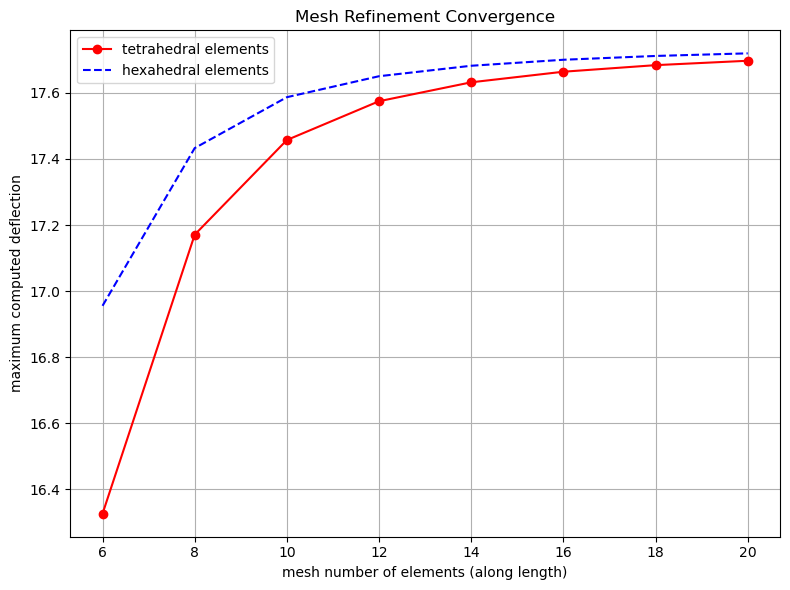

In [13]:
# Plot the max deflection values computed for each mesh size and element type
plt.figure(figsize=(8, 6))
mesh_xnum = [i_nx + 1 for i_nx in nx]
plt.plot(mesh_xnum, tetra_disps, 'ro-', label="tetrahedral elements")
plt.plot(mesh_xnum, hexa_disps, 'b--', label="hexahedral elements")
plt.xlabel("mesh number of elements (along length)")
plt.ylabel("maximum computed deflection")
plt.title("Mesh Refinement Convergence")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot image
tutorials_dir = os.path.abspath('')
img_fname = tutorials_dir + "/b-mesh-refinement-comparison.png"
plt.savefig(str(img_fname))

As we can see from the plot, the results converge with an increasing number of elements (h-refinement), as well as with the use of higher-order elements (p-refinement), in this case with hexahedral elements instead of tetrahedral.